In [36]:
import pandas as pd
from feature_engine.discretisation import DecisionTreeDiscretiser
import matplotlib.pyplot as plt
import funciones
import pygad

In [2]:
bFlavor_1M_train = pd.read_csv('bFlavor_train_1M_muestra.csv')
#Dataframe para discretizar y hacer experimento.
df_10k = bFlavor_1M_train.sample(n=10000, random_state=42).copy()

In [7]:
df_10k

conteo = df_10k['target_flavor'].value_counts(normalize=True) * 100
print("Distribución de Clases:")
print(f"B0 (Positivos - 1): {conteo[1]:.2f}%")
print(f"anti-B0 (Negativos - 0): {conteo[0]:.2f}%")
print(f"tamanio de la muestra:{conteo.shape}")

Distribución de Clases:
B0 (Positivos - 1): 49.93%
anti-B0 (Negativos - 0): 50.07%
tamanio de la muestra:(2,)


T1_charge             0.0000
T1_p                  0.0000
T1_cosTheta           0.0000
T1_phi                0.0000
T1_kaonID             0.0031
T1_elecID             0.0031
T1_muonID             0.0031
T1_protID             0.0031
T1_nCDCHits           0.0000
T1_nPXDHits           0.0000
T1_nSVDHits           0.0000
T1_dz                 0.0000
T1_dr                 0.0000
T1_chiProb            0.0000
T1_EW90               0.0000
T1_recoilMassSqrd     0.0000
T1_pMissCMS           0.0000
T1_cosThetaMissCMS    0.0000
T1_cosTPTO            0.0000
T2_charge             1.0205
dtype: float64


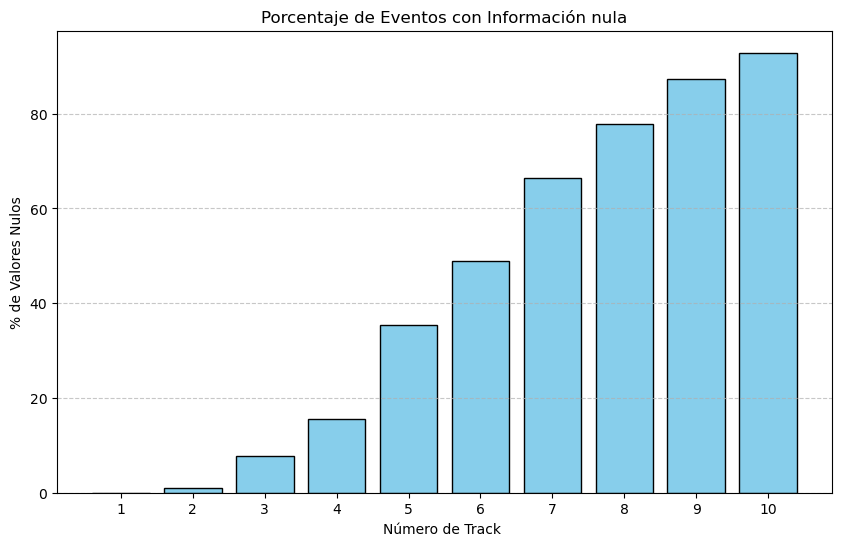

In [12]:
# Porcentaje de NaNs por columna (primeras pistas vs últimas)
nulls = bFlavor_1M_train.isnull().mean() * 100
print(nulls.head(20)) 

# Agrupamos los nulos por track, tomando el momento como referencia
pistas = [f'T{i}_charge' for i in range(1, 11)]
nulos_por_track = [nulls[p] for p in pistas]

plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), nulos_por_track, color='skyblue', edgecolor='black')
plt.title('Porcentaje de Eventos con Información nula')
plt.xlabel('Número de Track ')
plt.ylabel('% de Valores Nulos')
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# min, max y cantidad de nulos
resumen_rangos = df_10k.agg(['min', 'max', lambda x: x.isnull().sum()]).transpose()
resumen_rangos.columns = ['Mínimo', 'Máximo', 'Valores NaN']


print(resumen_rangos.head(19)) # Variables de la Track_1
print("-"*30)
print(resumen_rangos.tail(19)) # Variables de la Track_10

                          Mínimo      Máximo  Valores NaN
T1_charge          -1.000000e+00    1.000000          0.0
T1_p                9.611105e-02   39.077473          0.0
T1_cosTheta        -9.933821e-01    0.994587          0.0
T1_phi             -3.140661e+00    3.141257          0.0
T1_kaonID           0.000000e+00    1.000000          0.0
T1_elecID           0.000000e+00    1.000000          0.0
T1_muonID           0.000000e+00    1.000000          0.0
T1_protID           0.000000e+00    1.000000          0.0
T1_nCDCHits         0.000000e+00    2.571429          0.0
T1_nPXDHits         0.000000e+00    1.500000          0.0
T1_nSVDHits         0.000000e+00    2.000000          0.0
T1_dz              -2.648620e+02  376.305020          0.0
T1_dr               1.183257e-06   88.611015          0.0
T1_chiProb          0.000000e+00    1.000000          0.0
T1_EW90             0.000000e+00    8.911683          0.0
T1_recoilMassSqrd   1.740800e-08   20.243930          0.0
T1_pMissCMS   

In [23]:
columnas_features = df_10k.columns[:190].tolist()
X_10k = df_10k[columnas_features]
y_10k = df_10k['target_flavor']

#Manejo de nulos

X_10k_sin_nulos = X_10k.fillna(-999)

In [ ]:
nulos_despues = X_10k_sin_nulos.isnull().sum().sum()
print(f"TNulos {nulos_despues}")

Total de valores nulos después del llenado: 0


In [28]:
discretizador = DecisionTreeDiscretiser(
    bin_output="bin_number", #id del grupo
    cv=3,                    # Validacion cruzada
    scoring="roc_auc",       
    variables=columnas_features, 
    regression=False
)

# encontrar los cortes
discretizador.fit(X_10k_sin_nulos, y_10k)
X_10k_disc = discretizador.transform(X_10k_sin_nulos)

#Dataframe discretizado
df_10k_discretizado = pd.concat([X_10k_disc.reset_index(drop=True), y_10k.reset_index(drop=True)], axis=1)

In [29]:
df_10k_discretizado

,T1_charge,T1_p,T1_cosTheta,T1_phi,T1_kaonID,T1_elecID,T1_muonID,T1_protID,T1_nCDCHits,T1_nPXDHits,...,T10_nSVDHits,T10_dz,T10_dr,T10_chiProb,T10_EW90,T10_recoilMassSqrd,T10_pMissCMS,T10_cosThetaMissCMS,T10_cosTPTO,target_flavor
0,0,6,7,13,13,13,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,6,7,13,0,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,6,7,0,13,10,3,7,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,6,7,0,13,1,3,10,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,6,7,0,13,12,1,7,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,6,7,13,13,12,0,7,3,0,...,2,0,0,0,0,0,3,0,1,0
9996,0,6,7,13,5,0,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
9997,1,6,7,13,13,12,3,10,0,0,...,0,0,0,0,0,0,0,0,0,1
9998,1,6,7,13,13,13,3,7,1,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
df_10k_discretizado.describe()

df_10k_discretizado.to_csv('df_10k_discretizado.csv')

Ejecutando AG para N = 100...
Ejecutando AG para N = 500...
Ejecutando AG para N = 1000...
Ejecutando AG para N = 1500...
Ejecutando AG para N = 2000...


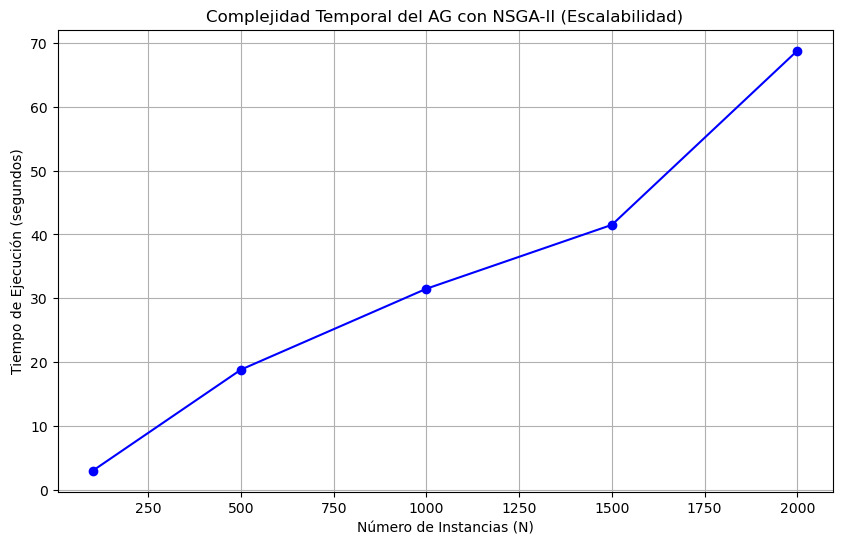

In [37]:
import time


instancias_lista = [100, 500, 1000, 1500, 2000]
tiempos_ejecucion = []

for N in instancias_lista:
    print(f"Ejecutando AG para N = {N}...")
    
    # tomamos el subconjunto discretizado
    df_prueba = df_10k_discretizado.iloc[:N]
    
    start_time = time.time()
    
    # CONFIGURACIÓN DEL GA (Ajustada para que termine rápido en el test)
    ga_instance = pygad.GA(
        num_generations=5,        # Pocas generaciones para el experimento de tiempo
        num_parents_mating=10,
        fitness_func=lambda ga, sol, idx: funciones.fitness_mod_nsga2(sol, df_prueba, columnas_features, 'target_flavor'),
        sol_per_pop=20,           # Población constante para medir solo el impacto de N
        num_genes=190,
        gene_type=int,
        init_range_low=0,
        init_range_high=2,
        parent_selection_type="tournament_nsga2",
        mutation_probability=0.000358
    )
    
    ga_instance.run()
    
    end_time = time.time()
    tiempos_ejecucion.append(end_time - start_time)

# resultados
plt.figure(figsize=(10, 6))
plt.plot(instancias_lista, tiempos_ejecucion, marker='o', linestyle='-', color='b')
plt.title('Complejidad Temporal del AG con NSGA-II (Escalabilidad)')
plt.xlabel('Número de Instancias (N)')
plt.ylabel('Tiempo de Ejecución (segundos)')
plt.grid(True)
plt.show()